#### ПРОЕКТ ПО ОПРЕДЕЛЕНИЮ ПРИЗНАКОВ УСПЕШНЫХ САЛОНОВ


## Бизнес-задача
Контекст:
Есть торговый центр, который специализируется в области мебели и товаров для ремонта и интерьера. Его бизнес: сдача в аренду площадей отдельным магазинам. Центр заинтересован минимизировать затраты на поиск и смену арендаторов. Поэтому центр хочет привлекать арендаторов которые успешно ведут бизнес (соответственно предполагается, что они с меньшей вероятностью откажутся от продления аренды).

Бизнес задача: иметь возможность заранее предсказать будет ли арендатор успешным.

## Данные для решения задачи
Есть данные опроса о результатах работы салонов (по продаже мебели) в 2023 году и их ожиданиях от 2024. Также есть данные о специфике салонов и их стратегии.
Все данные получены в ходе анкетного опроса (среди существующих арендаторов) и отражают мнение салонов о себе и о рынке.
Выявлена группа салонов - `оптимистов`. Варианты их признаков: положительная оценка 2023 года и положительный прогноз на 2024 год, положительная оценка 2023 или 2024 и нейтральная оценка другого года. Соответственно это салоны которые ожидают роста рынка в течение 2х лет или стабильного рынка в один год и роста в другой.
Предварительный анализ показывает, что попавшие в группу `оптимистов` более позитивны в отношении сохранения аренды, а также лучше оценивают результаты своего салона в 2023 году.
Мы не можем использовать прямую оценку работы салона в 2023 году, т.к. многие респонденты дали ответ "затрудняюсь ответить", возможно это связано с нежеланием показывать арендодателю свой успех и желании избежать повышения арендной ставки.

Задача: понять как идентифицировать такие салоны (каких признаки показывают вероятное отнесение салона к группе "оптимистов") и можно ли сделать модель предсказания "оптимизма" по другим признакам.

Нюансы: всего собрано 111 анкет. Таким образом, у нас сравнительно небольшая база данных для построения моделей и их тестирования.



#### Блок подготовка и анализ данных

In [1]:
#Загрузка библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from itertools import combinations
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score  
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow import keras

import xgboost as xgb


pd.set_option('display.max_columns', None)

C:\Users\OLEG\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Загрузка данных

df= pd.read_csv(r'C:\Users\OLEG\Jupyter\Shops_project\data_for_py.csv', sep=';')
df.head(8)

,ID_shop,Square,Type_shop,Whosale,Rooms_f,Kitchen_f,Decor,Light,Bathroom_f,Wall_f,Floor_f,Doors_f,Street_f,Ingener_f,Child_f,Low_p,Mid_p,MidPlus_p,Premium_p,Elite_p,Designers_sale,Consumer_sale,Grow_shops,Est2023_3,Est2023_5,salon_2023_3,salon_2023_3.1,est2024,show_goods,trust,meeting,flagman,Partners,ofice,new_clients,exhibitions,hold_designers,convert_to_byers,consumers,bulders,young_designers,competitors_designers,outside-designers,other-regions,sales_to-loyality,ads-activity,promo_plans
0,83949977.0,"132,3",f,k,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,ИСТИНА,2.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,2.0,6.0,8.0,5.0,7.0,9.0,4.0,3.0,2.0
1,83897331.0,"159,3",f,s,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,4.0,ИСТИНА,2.0,2.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,3.0,4.0,1.0,5.0,6.0,8.0,7.0,9.0,7.0,7.0
2,83774550.0,"71,75",s,s,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,4.0,ЛОЖЬ,-2.0,-2.0,-2.0,-1.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,4.0,6.0,1.0,5.0,9.0,7.0,8.0,2.0,2.0,2.0
3,83740214.0,143,f,n,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,ЛОЖЬ,-2.0,-1.0,-2.0,-1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,5.0,4.0,6.0,7.0,8.0,9.0,3.0,0.0
4,83734709.0,"188,54",f,s,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,ЛОЖЬ,-2.0,-1.0,-2.0,-1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5.0,3.0,1.0,2.0,7.0,8.0,9.0,6.0,4.0,8.0,0.0
5,83730865.0,51,s,o,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,2.0,ЛОЖЬ,-2.0,-1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,4.0,0.0
6,83730366.0,168,n,n,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,ЛОЖЬ,-2.0,-1.0,-2.0,-1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,3.0,2.0,4.0,5.0,7.0,8.0,9.0,7.0,1.0
7,83730188.0,"82,6",f,n,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,3.0,ИСТИНА,0.0,0.0,-2.0,-1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,4.0,5.0


In [3]:
df.describe()

,ID_shop,Rooms_f,Kitchen_f,Decor,Light,Bathroom_f,Wall_f,Floor_f,Doors_f,Street_f,Ingener_f,Child_f,Low_p,Mid_p,MidPlus_p,Premium_p,Elite_p,Designers_sale,Consumer_sale,Est2023_3,Est2023_5,salon_2023_3,salon_2023_3.1,est2024,show_goods,trust,meeting,flagman,Partners,ofice,new_clients,exhibitions,hold_designers,convert_to_byers,consumers,bulders,young_designers,competitors_designers,outside-designers,other-regions,sales_to-loyality,ads-activity,promo_plans
count,1.110000e+02,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.0,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,111.000000,111.000000
mean,8.284101e+07,0.378378,0.216216,0.279279,0.243243,0.063063,0.171171,0.117117,0.081081,0.090090,0.126126,0.027027,0.0,0.135135,0.603604,0.675676,0.216216,1.846847,1.900901,0.090090,0.108108,-0.432432,-0.324324,0.828829,0.846847,0.594595,0.765766,0.270270,0.252252,0.387387,0.378378,0.252252,1.912621,3.417476,3.242718,4.116505,5.194175,6.252427,7.262136,7.631068,6.271845,3.720721,2.126126
std,4.207430e+05,0.487182,0.413530,0.450680,0.430987,0.244179,0.378367,0.323018,0.274198,0.287609,0.333497,0.162898,0.0,0.343418,0.491367,0.470245,0.413530,0.854913,0.841589,1.776358,1.274586,1.437306,0.885871,1.387436,0.361768,0.493197,0.425440,0.446113,0.436275,0.489363,0.487182,0.436275,1.205435,1.683392,2.016919,1.682091,1.515012,1.557515,0.969750,1.914805,3.042813,2.347808,2.203786
min,8.247082e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,0.000000,0.000000
25%,8.251979e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-2.000000,-1.000000,-2.000000,-1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,3.000000,5.000000,6.000000,7.000000,8.000000,4.000000,2.000000,0.000000
50%,8.281284e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,7.000000,4.000000,2.000000
75%,8.291823e+07,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,0.500000,2.000000,4.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,9.000000,5.000000,3.000000
max,8.394998e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,10.000000,9.000000,9.000000,9.000000,9.000000,9.000000,10.000000,10.000000,10.000000,7.000000


In [4]:
print(df.columns)

Index(['ID_shop', 'Square', 'Type_shop', 'Whosale', 'Rooms_f', 'Kitchen_f',
       'Decor', 'Light', 'Bathroom_f', 'Wall_f', 'Floor_f', 'Doors_f',
       'Street_f', 'Ingener_f', 'Child_f', 'Low_p', 'Mid_p', 'MidPlus_p',
       'Premium_p', 'Elite_p', 'Designers_sale', 'Consumer_sale', 'Grow_shops',
       'Est2023_3', 'Est2023_5', 'salon_2023_3', 'salon_2023_3.1', 'est2024',
       'show_goods', 'trust', 'meeting', 'flagman', 'Partners', 'ofice',
       'new_clients', 'exhibitions', 'hold_designers', 'convert_to_byers',
       'consumers', 'bulders', 'young_designers', 'competitors_designers',
       'outside-designers', 'other-regions', 'sales_to-loyality',
       'ads-activity', 'promo_plans'],
      dtype='object')


#### Описание переменых
- 'ID_shop' - нормер магазина
- 'Square' - площадь магазина, число
- 'Type_shop' - тип магазина: сетевой или единственный
- 'Whosale' - занимается ли оптовыми продажами
- 'Rooms_f', 'Kitchen_f', 'Decor', 'Light', 'Bathroom_f', 'Wall_f', 'Floor_f', 'Doors_f',
       'Street_f', 'Ingener_f', 'Child_f' - виды продаваемых товаров (0/1)
- 'Low_p', 'Mid_p', 'MidPlus_p', 'Premium_p', 'Elite_p', - какой ценовой уровень у магазина (0/1)
- 'Designers_sale', 'Consumer_sale', - уровень приоритета дизайнеров и конечных потребителей (от 1 до 4, 1 - самый важный)
- 'Grow_shops', - растущие магазины: положительный или нейтральный прогноз по 2023 и 2024 гг
- 'Est2023_3', 'Est2023_5', 'salon_2023_3', 'salon_2023_3.1', 'est2024', - оценка 2023 рынка, оценка 2023 салона (шкалы на 3 и 5 значений) прогноз на 2024 (шкала на 3)
- 'show_goods', 'trust', 'meeting', 'flagman', 'Partners', 'ofice', - какие функции выполняет салон
- 'new_clients', 'exhibitions', 'hold_designers', 'convert_to_byers', 'consumers', 'bulders', 'young_designers', 'competitors_designers', - планы по работе с разными аудиториями 
- 'outside-designers', 'other-regions', 'sales_to-loyality', - приоритеты целей по типам клиентов (шкала от 1 до 10, 1 макс)
- 'ads-activity', - сколько видов рек активностей использовали в 2023 году (число)
- 'promo_plans' - сколько видов активностей хотят использовать в 2024 году (число)

In [5]:
#перевожу названия столбцов в нижний регистр, чтобы не путаться

df = df.copy()
df.rename(columns=lambda x: x.lower(), inplace=True)

In [6]:
print(df.columns)

Index(['id_shop', 'square', 'type_shop', 'whosale', 'rooms_f', 'kitchen_f',
       'decor', 'light', 'bathroom_f', 'wall_f', 'floor_f', 'doors_f',
       'street_f', 'ingener_f', 'child_f', 'low_p', 'mid_p', 'midplus_p',
       'premium_p', 'elite_p', 'designers_sale', 'consumer_sale', 'grow_shops',
       'est2023_3', 'est2023_5', 'salon_2023_3', 'salon_2023_3.1', 'est2024',
       'show_goods', 'trust', 'meeting', 'flagman', 'partners', 'ofice',
       'new_clients', 'exhibitions', 'hold_designers', 'convert_to_byers',
       'consumers', 'bulders', 'young_designers', 'competitors_designers',
       'outside-designers', 'other-regions', 'sales_to-loyality',
       'ads-activity', 'promo_plans'],
      dtype='object')


In [7]:
replacement_dict = {'ИСТИНА': 1, 'ЛОЖЬ': 0}
df['grow_shops'] = df['grow_shops'].map(replacement_dict)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_shop                111 non-null    float64
 1   square                 110 non-null    object 
 2   type_shop              111 non-null    object 
 3   whosale                111 non-null    object 
 4   rooms_f                111 non-null    float64
 5   kitchen_f              111 non-null    float64
 6   decor                  111 non-null    float64
 7   light                  111 non-null    float64
 8   bathroom_f             111 non-null    float64
 9   wall_f                 111 non-null    float64
 10  floor_f                111 non-null    float64
 11  doors_f                111 non-null    float64
 12  street_f               111 non-null    float64
 13  ingener_f              111 non-null    float64
 14  child_f                111 non-null    float64
 15  low_p 

In [9]:
print(df['grow_shops'])     

0      1.0
1      1.0
2      0.0
3      0.0
4      0.0
      ... 
108    0.0
109    0.0
110    0.0
111    NaN
112    NaN
Name: grow_shops, Length: 113, dtype: float64


In [10]:
#удалил две лишние последние строки, какая-то ошибка исходного файла. их не было в изначальных данных
df = df.iloc[:-2]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_shop                111 non-null    float64
 1   square                 110 non-null    object 
 2   type_shop              111 non-null    object 
 3   whosale                111 non-null    object 
 4   rooms_f                111 non-null    float64
 5   kitchen_f              111 non-null    float64
 6   decor                  111 non-null    float64
 7   light                  111 non-null    float64
 8   bathroom_f             111 non-null    float64
 9   wall_f                 111 non-null    float64
 10  floor_f                111 non-null    float64
 11  doors_f                111 non-null    float64
 12  street_f               111 non-null    float64
 13  ingener_f              111 non-null    float64
 14  child_f                111 non-null    float64
 15  low_p 

In [12]:
#Проверка пропусков

df.isna().sum()

id_shop                  0
square                   1
type_shop                0
whosale                  0
rooms_f                  0
kitchen_f                0
decor                    0
light                    0
bathroom_f               0
wall_f                   0
floor_f                  0
doors_f                  0
street_f                 0
ingener_f                0
child_f                  0
low_p                    0
mid_p                    0
midplus_p                0
premium_p                0
elite_p                  0
designers_sale           0
consumer_sale            0
grow_shops               0
est2023_3                0
est2023_5                0
salon_2023_3             0
salon_2023_3.1           0
est2024                  0
show_goods               0
trust                    0
meeting                  0
flagman                  0
partners                 0
ofice                    0
new_clients              0
exhibitions              0
hold_designers           8
c

In [13]:
df = df.fillna(0)

In [14]:
df.isna().sum()

id_shop                  0
square                   0
type_shop                0
whosale                  0
rooms_f                  0
kitchen_f                0
decor                    0
light                    0
bathroom_f               0
wall_f                   0
floor_f                  0
doors_f                  0
street_f                 0
ingener_f                0
child_f                  0
low_p                    0
mid_p                    0
midplus_p                0
premium_p                0
elite_p                  0
designers_sale           0
consumer_sale            0
grow_shops               0
est2023_3                0
est2023_5                0
salon_2023_3             0
salon_2023_3.1           0
est2024                  0
show_goods               0
trust                    0
meeting                  0
flagman                  0
partners                 0
ofice                    0
new_clients              0
exhibitions              0
hold_designers           0
c

In [15]:
df['square'] = df['square'].astype(str)


df['square'] = df['square'].str.replace(',', '.')


df['square'] = df['square'].astype(float)


df['square'] = df['square'].round().astype(int)

In [16]:
#перевожу все значения в возможные значения в целочисленные для ускорения рассчетов

columns_names = ['id_shop', 'rooms_f', 'kitchen_f',
       'decor', 'light', 'bathroom_f', 'wall_f', 'floor_f', 'doors_f',
       'street_f', 'ingener_f', 'child_f', 'low_p', 'mid_p', 'midplus_p',
       'premium_p', 'elite_p', 'designers_sale', 'consumer_sale', 'grow_shops',
       'est2023_3', 'est2023_5', 'salon_2023_3', 'salon_2023_3.1', 'est2024',
       'show_goods', 'trust', 'meeting', 'flagman', 'partners', 'ofice',
       'new_clients', 'exhibitions', 'hold_designers', 'convert_to_byers',
       'consumers', 'bulders', 'young_designers', 'competitors_designers',
       'outside-designers', 'other-regions', 'sales_to-loyality',
       'ads-activity', 'promo_plans']

for i in columns_names:
    df[i] = df[i].astype(int)


#### Блок анализ зависимостей и описание данных

Text(0, 0.5, 'Частота')

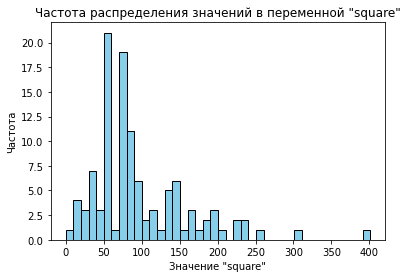

In [17]:
# Создание гистограммы
plt.hist(df['square'], bins=40        
         , color='skyblue', edgecolor='black')

# Добавление названия и подписей осей
plt.title('Частота распределения значений в переменной "square"')
plt.xlabel('Значение "square"')
plt.ylabel('Частота')

In [18]:
#создаю переменные, показывающие категорию салона по площади

df['less_than_60'] = (df['square'] < 60).astype(int)
df['61_less_100'] = ((df['square'] < 100) & (df['square'] >= 60)).astype(int)
df['greater_than_150'] = (df['square'] > 150).astype(int)

In [19]:
#Новая переменная показывает сколько видов товаров у салона (уровень специализации / универсальности)

df['sum_features'] = df[['rooms_f', 'kitchen_f',
       'decor', 'light', 'bathroom_f', 'wall_f', 'floor_f', 'doors_f',
       'street_f', 'ingener_f', 'child_f']].sum(axis=1)


In [20]:
df['grow_shops'].describe()

count    111.000000
mean       0.405405
std        0.493197
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: grow_shops, dtype: float64

In [21]:
df.groupby('grow_shops').mean().round(1)

,id_shop,square,rooms_f,kitchen_f,decor,light,bathroom_f,wall_f,floor_f,doors_f,street_f,ingener_f,child_f,low_p,mid_p,midplus_p,premium_p,elite_p,designers_sale,consumer_sale,est2023_3,est2023_5,salon_2023_3,salon_2023_3.1,est2024,show_goods,trust,meeting,flagman,partners,ofice,new_clients,exhibitions,hold_designers,convert_to_byers,consumers,bulders,young_designers,competitors_designers,outside-designers,other-regions,sales_to-loyality,ads-activity,promo_plans,less_than_60,61_less_100,greater_than_150,sum_features
grow_shops,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,82830535.5,97.6,0.4,0.2,0.3,0.3,0.1,0.2,0.2,0.1,0.1,0.1,0.0,0.0,0.2,0.6,0.7,0.2,1.8,1.8,-1.1,-0.7,-1.0,-0.7,0.2,0.9,0.6,0.7,0.2,0.2,0.4,0.4,0.3,1.7,3.3,2.7,4.0,4.6,5.6,6.6,6.7,5.5,3.4,1.7,0.3,0.3,0.2,1.9
1,82856364.4,97.3,0.4,0.2,0.3,0.2,0.0,0.1,0.1,0.1,0.1,0.2,0.0,0.0,0.1,0.6,0.7,0.2,1.9,2.0,1.8,1.3,0.4,0.2,1.7,0.8,0.6,0.8,0.4,0.4,0.4,0.4,0.2,1.8,3.0,3.4,3.6,5.1,6.1,7.0,7.7,6.3,4.2,2.7,0.3,0.3,0.2,1.6


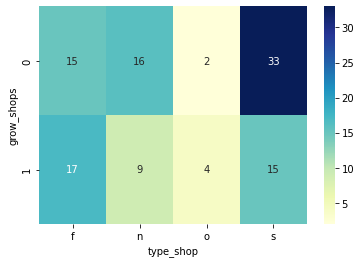

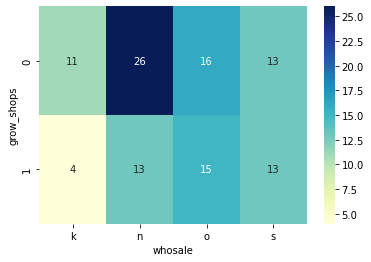

In [22]:
cross_table = pd.crosstab(df['grow_shops'], df['type_shop'])

# Создание тепловой карты  , 'whosale'
sns.heatmap(cross_table, annot=True, cmap="YlGnBu")

# Добавление названий осей
plt.xlabel('type_shop')
plt.ylabel('grow_shops')

# Отображение тепловой карты
plt.show()


cross_table = pd.crosstab(df['grow_shops'], df['whosale'])

# Создание тепловой карты  , 
sns.heatmap(cross_table, annot=True, cmap="YlGnBu")

# Добавление названий осей
plt.xlabel('whosale')
plt.ylabel('grow_shops')

# Отображение тепловой карты
plt.show()

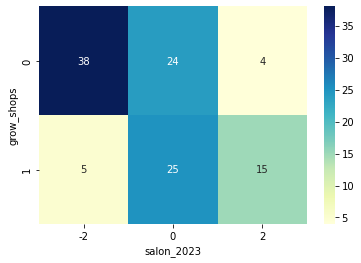

In [23]:
cross_table = pd.crosstab(df['grow_shops'], df['salon_2023_3'])

# Создание тепловой карты  , 'whosale'
sns.heatmap(cross_table, annot=True, cmap="YlGnBu")

# Добавление названий осей
plt.xlabel('salon_2023')
plt.ylabel('grow_shops')

# Отображение тепловой карты
plt.show()


ОКОЛО 40% САЛОНОВ ОТНОСЯТСЯ К ГРУППЕ ОПТИМИСТОВ

ПРИЗНАКИ РАСТУЩИХ САЛОНОВ:


Что не влияет: 
- площадь салона, 
- типы товаров, 
- ценовые уровни

Что влияет:
- Более высокая специализация 
- Большая активность (рекламная и готовность участвовать в акциях)
- Флагманские салоны наиболее оптимистичны, одиночные салоны и не занимающиеся оптовыми продажами - наименее

- Для растущих салонов (`оптимистов`) характерен успешный 2023 год, для нерастущих - неудачный 2023. На Heatmap видна большая часть давших нейтральный ответ или "затрудняюсь ответить"
- Таким образом мы можем считать показать `оптимисты` релевантно отражает успешность бизнеса.

In [24]:
df['est2024'].describe()

count    111.000000
mean       0.828829
std        1.387436
min       -2.000000
25%        0.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: est2024, dtype: float64

In [25]:
df.groupby('est2024').mean().round(2)

,id_shop,square,rooms_f,kitchen_f,decor,light,bathroom_f,wall_f,floor_f,doors_f,street_f,ingener_f,child_f,low_p,mid_p,midplus_p,premium_p,elite_p,designers_sale,consumer_sale,grow_shops,est2023_3,est2023_5,salon_2023_3,salon_2023_3.1,show_goods,trust,meeting,flagman,partners,ofice,new_clients,exhibitions,hold_designers,convert_to_byers,consumers,bulders,young_designers,competitors_designers,outside-designers,other-regions,sales_to-loyality,ads-activity,promo_plans,less_than_60,61_less_100,greater_than_150,sum_features
est2024,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-2,82913005.00,77.23,0.38,0.15,0.15,0.38,0.15,0.08,0.15,0.08,0.15,0.15,0.00,0.0,0.08,0.77,0.69,0.08,1.69,1.77,0.00,-1.08,-0.92,-1.38,-1.00,0.77,0.62,0.69,0.00,0.15,0.38,0.15,0.08,1.62,3.62,3.00,4.00,5.38,5.85,7.23,6.38,4.77,3.62,1.54,0.46,0.31,0.15,1.85
0,82720363.59,105.79,0.41,0.26,0.36,0.21,0.08,0.18,0.10,0.15,0.08,0.10,0.03,0.0,0.26,0.54,0.54,0.33,1.92,1.72,0.18,-0.31,-0.18,-0.51,-0.41,0.90,0.49,0.72,0.33,0.21,0.33,0.41,0.28,1.64,2.97,2.28,3.85,4.46,5.41,6.26,6.77,5.79,3.23,1.28,0.33,0.33,0.18,1.95
2,82904889.71,96.46,0.36,0.20,0.25,0.24,0.03,0.19,0.12,0.03,0.08,0.14,0.03,0.0,0.07,0.61,0.76,0.17,1.83,2.05,0.64,0.61,0.53,-0.17,-0.12,0.83,0.66,0.81,0.29,0.31,0.42,0.41,0.27,1.90,3.20,3.49,3.76,4.93,6.05,6.95,7.44,6.07,4.07,2.81,0.31,0.34,0.15,1.68


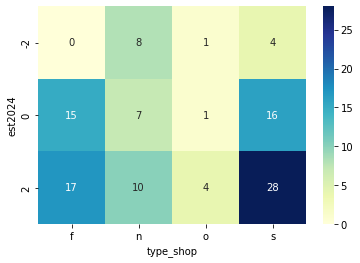

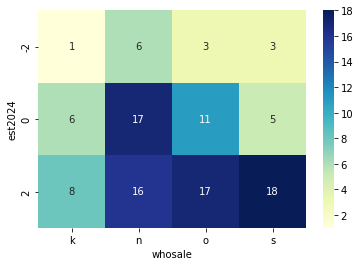

In [26]:
cross_table = pd.crosstab(df['est2024'], df['type_shop'])

# Создание тепловой карты  , 'whosale'
sns.heatmap(cross_table, annot=True, cmap="YlGnBu")

# Добавление названий осей
plt.xlabel('type_shop')
plt.ylabel('est2024')

# Отображение тепловой карты
plt.show()


cross_table = pd.crosstab(df['est2024'], df['whosale'])

# Создание тепловой карты  , 
sns.heatmap(cross_table, annot=True, cmap="YlGnBu")

# Добавление названий осей
plt.xlabel('whosale')
plt.ylabel('est2024')

# Отображение тепловой карты
plt.show()

ОКОЛО 80% САЛОНОВ ОЖИДАЮТ УЛУЧШЕНИЯ КОНЪЮНКТУРЫ В 2024 ГОДУ

ПРИЗНАКИ САЛОНОВ ОЖИДАЮЩИХ РОСТА ИЛИ СПАДА В 2024 ГОДУ:

ОЖИДАЮТ СПАД:
- Чаще небольшие салоны до 60 м.кв.
- Чаще: Продавцы светильников и светового оборудования, уличной мебели
- Имели плохие продажи в 2023 году и оценивали рынок в 2023 году как падающий
- Чаще стараются удержать существующих дизайнеров, привлечь частных лиц - более традиционный взгляд на формирование клиентской базы


ОЖИДАЮТ РОСТ:
- Флагманские салоны и одиночные. Наименее оптимистичны не флагманские сетевые салоны
- Чаще продавцы настенных покрытий 
- Чаще флагманские салоны, работа с партнерами
- Чаще ищут новых клиентов, больше внимания расширению клиентской базы из разных источников
- Больше видов рекламной активности, большая готовность участововать в новых активностях на АП

In [27]:
print(df.columns)

Index(['id_shop', 'square', 'type_shop', 'whosale', 'rooms_f', 'kitchen_f',
       'decor', 'light', 'bathroom_f', 'wall_f', 'floor_f', 'doors_f',
       'street_f', 'ingener_f', 'child_f', 'low_p', 'mid_p', 'midplus_p',
       'premium_p', 'elite_p', 'designers_sale', 'consumer_sale', 'grow_shops',
       'est2023_3', 'est2023_5', 'salon_2023_3', 'salon_2023_3.1', 'est2024',
       'show_goods', 'trust', 'meeting', 'flagman', 'partners', 'ofice',
       'new_clients', 'exhibitions', 'hold_designers', 'convert_to_byers',
       'consumers', 'bulders', 'young_designers', 'competitors_designers',
       'outside-designers', 'other-regions', 'sales_to-loyality',
       'ads-activity', 'promo_plans', 'less_than_60', '61_less_100',
       'greater_than_150', 'sum_features'],
      dtype='object')


##### Рассмотрим зависимости между переменными
Применим коэффициенты Крамера и Метьюса, т.к. многие данные категорийные и многие бинарные

In [28]:
# Функция для вычисления коэффициента Фи Крамера

df_cr = df[['rooms_f', 'kitchen_f',
       'decor', 'light', 'bathroom_f', 'wall_f', 'floor_f', 'doors_f',
       'street_f', 'ingener_f', 'child_f', 'low_p', 'mid_p', 'midplus_p',
       'premium_p', 'elite_p', 'designers_sale', 'consumer_sale', 'grow_shops',
       'est2023_3', 'est2023_5', 'salon_2023_3', 'salon_2023_3.1', 'est2024',
       'show_goods', 'trust', 'meeting', 'flagman', 'partners', 'ofice',
       'new_clients', 'exhibitions', 'hold_designers', 'convert_to_byers',
       'consumers', 'bulders', 'young_designers', 'competitors_designers',
       'outside-designers', 'other-regions', 'sales_to-loyality',
       'ads-activity', 'promo_plans', 
       'sum_features', 'greater_than_150', 'less_than_60', '61_less_100']]

def compute_cramer_v(df_cr, var1, var2):
    cross_table = pd.crosstab(df_cr[var1], df_cr[var2])
    chi2, _, _, _ = chi2_contingency(cross_table)
    n = cross_table.sum().sum()
    phi_cramer = np.sqrt(chi2 / (n * (min(cross_table.shape) - 1)))
    return phi_cramer

# Получение всех возможных комбинаций пар переменных
variables = df_cr.columns
pairs = list(combinations(variables, 2))

# Создание DataFrame для сохранения результатов
results = pd.DataFrame(columns=['Variable1', 'Variable2', 'Cramer_V'])

# Расчет коэффициента Фи Крамера для каждой пары переменных
for var1, var2 in pairs:
    cramer_v = compute_cramer_v(df_cr, var1, var2).round(2)
    results = results.append({'Variable1': var1, 'Variable2': var2, 'Cramer_V': cramer_v}, ignore_index=True)

pd.set_option('display.max_rows', None)


sorted_results = results.sort_values(by='Cramer_V', ascending=False)

# Вывод отсортированного списка DataFrame
print(sorted_results)




C:\Users\OLEG\AppData\Local\Temp/ipykernel_11560/3759058013.py:19: RuntimeWarning: invalid value encountered in divide
  phi_cramer = np.sqrt(chi2 / (n * (min(cross_table.shape) - 1)))


                  Variable1              Variable2  Cramer_V
703               est2023_3              est2023_5      1.00
756            salon_2023_3         salon_2023_3.1      1.00
676              grow_shops              est2023_5      0.82
675              grow_shops              est2023_3      0.81
1045      outside-designers          other-regions      0.63
730               est2023_5           salon_2023_3      0.62
983          hold_designers      sales_to-loyality      0.61
0                   rooms_f              kitchen_f      0.61
1036  competitors_designers      outside-designers      0.61
982          hold_designers          other-regions      0.60
977          hold_designers              consumers      0.60
1027        young_designers      outside-designers      0.59
976          hold_designers       convert_to_byers      0.59
731               est2023_5         salon_2023_3.1      0.58
978          hold_designers                bulders      0.58
1037  competitors_design

In [29]:
# Функция для расчета коэффициента корреляции Мэтьюса
def compute_mcc(df, var1, var2):
    mcc = matthews_corrcoef(df[var1], df[var2])
    return mcc

# Получение всех возможных комбинаций пар переменных
variables = df_cr.columns
pairs = list(combinations(variables, 2))

# Создание DataFrame для сохранения результатов
results = pd.DataFrame(columns=['Variable1', 'Variable2', 'Matthews_Correlation'])

# Расчет коэффициента корреляции Мэтьюса для каждой пары переменных
for var1, var2 in pairs:
    mcc = compute_mcc(df_cr, var1, var2)
    results = results.append({'Variable1': var1, 'Variable2': var2, 'Matthews_Correlation': mcc}, ignore_index=True)

# Сортировка результатов по убыванию коэффициента корреляции Мэтьюса
sorted_results = results.sort_values(by='Matthews_Correlation', ascending=False)

# Вывод отсортированного списка DataFrame
print(sorted_results)


                  Variable1              Variable2  Matthews_Correlation
0                   rooms_f              kitchen_f              0.628079
220                  wall_f                floor_f              0.578303
756            salon_2023_3         salon_2023_3.1              0.477368
703               est2023_3              est2023_5              0.474859
704               est2023_3           salon_2023_3              0.462948
731               est2023_5         salon_2023_3.1              0.434437
179              bathroom_f                floor_f              0.366542
891                 flagman               partners              0.347162
54                kitchen_f                child_f              0.317324
871                 meeting                flagman              0.288687
833              show_goods            new_clients              0.280207
872                 meeting               partners              0.272252
103                   decor                elite_p 

ЗАВИСИМОСТИ:

Часто в продажах сочетаются:
мебель для комнат и кухонь
стены потолок и пол
ванные и напольные покрытия

флагманы чаще работают с партнерами и используют салон для встреч

сохраняющие продажи (дизайнеров и потребителей)

и ищущие новых чаще ищут и из других регионов и молодых дизайнеров

# Построение моделей


#### Применяемые модели


Logistic Regression


DecisionTreeClassifier

RandomForestClassifier


K-ближайших соседей (KNN)


Нейронная сеть с помощью Keras






мы не можем использовать данные о результатах салона за 2023 год, т.к. это результаты достигнутые в данном торговом центре. Соответственно, новый салон не может иметь такую информацию

In [30]:
#Создаю таблицу для сбора результатов моделей

columns = ['method', 'accuracy', 'optimists_from_recomend', 'optimists_from_unrecomend']

methods_compare = pd.DataFrame(columns=columns)

Таблица содержит показатель accuracy,а также 
Долю оптимистов среди рекомендованных (т.е. правильность выбора арендатора)
Долю оптимистов среди нерекомендованных (т.е. ошибочный отказ)

In [31]:
#функция для рассчета качества моделей и сравнения в таблице methods_compare

def mtrx (y_test, y_pred, name):
    
    from sklearn.metrics import confusion_matrix #по какой-то причине без прописывания здесь код не рассчитывает матрицу
    
    global methods_compare
    
    
    confusion_matrix = confusion_matrix(y_test, y_pred)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix)
    
    optimists_from_recomend = confusion_matrix[1,1]/(confusion_matrix[1,1] + confusion_matrix[0,1])
    optimists_from_unrecomend = confusion_matrix[1,0]/(confusion_matrix[1,0] + confusion_matrix[0,0])
    accuracy = accuracy_score(y_test, y_pred)

    # Выводим результаты
    print("optimists_from_recomend:", optimists_from_recomend.round(2))
    print("optimists_from_unrecomend:", optimists_from_unrecomend.round(2))
    
    methods_compare = methods_compare.append({'method': name, 
                                              'accuracy': accuracy.round(2), 
                                              'optimists_from_recomend' : optimists_from_recomend.round(2), 
                                              'optimists_from_unrecomend' : optimists_from_unrecomend.round(2)}, 
                                             ignore_index=True)



    
    return None

In [32]:
#Собираем объясняющие переменные. Часть данных бинарные, остальные категорийные - обрабатываем методом OHE
# Строим модель логистической регрессии

df_reg = df[['type_shop', 
       'ads-activity', 'promo_plans']]

df_bin = df[['rooms_f', 'kitchen_f',
       'decor', 'light', 'bathroom_f', 'wall_f', 'floor_f', 'doors_f',
       'street_f', 'ingener_f', 'child_f', 'mid_p', 'midplus_p',
       'premium_p', 'elite_p', 
       'greater_than_150', 'less_than_60', '61_less_100']]


encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(df_reg)

# Преобразование X_encoded в DataFrame
X_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_encoded, columns=encoder.get_feature_names_out(input_features=df_reg.columns))

# Объединение X_encoded_df с df_bin
X_combined = pd.concat([X_encoded_df, df_bin], axis=1)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['grow_shops'], test_size=0.2, random_state=42)

# Построение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Оценка производительности модели
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

# Делаем предсказания
y_pred = model.predict(X_test)

# Вычисляем Precision, Recall и F1-score

mtrx (y_test, y_pred, 'Log Reg full data') 

print('Коэффициенты модели:')
print(df_bin.columns)
print(f'Intercept: {model.coef_[0]}')

Accuracy: 0.5652173913043478
Confusion Matrix:
[[11  5]
 [ 5  2]]
optimists_from_recomend: 0.29
optimists_from_unrecomend: 0.31
Коэффициенты модели:
Index(['rooms_f', 'kitchen_f', 'decor', 'light', 'bathroom_f', 'wall_f',
       'floor_f', 'doors_f', 'street_f', 'ingener_f', 'child_f', 'mid_p',
       'midplus_p', 'premium_p', 'elite_p', 'greater_than_150', 'less_than_60',
       '61_less_100'],
      dtype='object')
Intercept: [ 0.43109904 -0.07659559  0.17885703 -0.53320732 -0.36610438 -0.11099343
 -0.00492056 -0.11173389 -0.08925825 -0.49486853  0.30794373  0.35158457
  0.51940396 -0.09076772  0.08986764 -1.21038256 -0.01697353  0.49276239
  0.13004179 -0.38423396  0.09272832  0.8879067   0.00830401 -0.15122589
 -0.33869761 -0.18942044 -0.1296913   0.18763742 -1.23008909 -1.05292338
 -0.5097865   0.95210093  0.44164955 -0.11019838 -0.63091378 -0.21962324
 -0.03692811 -0.16625245 -0.32968826 -0.04884873 -0.02008906]


C:\Users\OLEG\anaconda3\lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\OLEG\anaconda3\lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\OLEG\anaconda3\lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [33]:
# модель собрана по объясняющим переменным с наиболее высокими коэффициентами из предыдущей модели логистической регрессии

df['ads_activity_more5'] = np.where(df['ads-activity'] < 6, 0, 1)
df['promo_plans_0'] = np.where(df['promo_plans'] == 0, 0, 1)
df['type_shop_f'] = np.where(df['type_shop'] == 'f', 1, 0)
df['type_shop_s'] = np.where(df['type_shop'] == 's', 1, 0)

df_bin = df[['type_shop_f', 'type_shop_s', 'rooms_f', 'kitchen_f',
       'decor', 'light', 'bathroom_f', 'wall_f', 'floor_f', 'doors_f',
       'street_f', 'ingener_f', 'child_f', 'mid_p', 'midplus_p',
       'premium_p', 'elite_p', 'ads_activity_more5', 'promo_plans_0', 'partners', 
       'greater_than_150', 'less_than_60', '61_less_100']]


X_combined =df_bin

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['grow_shops'], test_size=0.2, random_state=42)

# Построение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Оценка производительности модели
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

# Делаем предсказания
y_pred = model.predict(X_test)

mtrx (y_test, y_pred, 'Log Reg 24') 

print('Коэффициенты модели:')
print(df_bin.columns)
print(f'Intercept: {model.coef_[0]}')


Accuracy: 0.6086956521739131
Confusion Matrix:
[[11  5]
 [ 4  3]]
optimists_from_recomend: 0.38
optimists_from_unrecomend: 0.27
Коэффициенты модели:
Index(['type_shop_f', 'type_shop_s', 'rooms_f', 'kitchen_f', 'decor', 'light',
       'bathroom_f', 'wall_f', 'floor_f', 'doors_f', 'street_f', 'ingener_f',
       'child_f', 'mid_p', 'midplus_p', 'premium_p', 'elite_p',
       'ads_activity_more5', 'promo_plans_0', 'partners', 'greater_than_150',
       'less_than_60', '61_less_100'],
      dtype='object')
Intercept: [ 0.30557244 -0.61757333 -0.15128046 -0.31479548 -0.12113502 -0.10869469
  0.26314219 -1.14292551 -1.01633962 -0.37921504  0.93405014  0.27396608
 -0.14730845 -0.6429437  -0.34132918 -0.27270097 -0.02153637  0.59918186
  1.31524152  0.82408297 -0.37589281 -0.03197468 -0.02652776]


In [58]:
# дополнительный отбор переменных. Убрал тип мебели и ценовой уровни, т.к. они блокируют 
#целые типы салонов, что резко сужает число потенциальных арендаторов и площадь менее 150, т.к. они пересекается с другиими переменными



df_bin_6 = df[['type_shop_f', 'type_shop_s', 'ads_activity_more5', 'promo_plans_0', 'partners', 
        'greater_than_150']]


X_combined =df_bin_6

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['grow_shops'], test_size=0.2, random_state=42)

# Построение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Оценка производительности модели
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

# Делаем предсказания
y_pred = model.predict(X_test)

mtrx (y_test, y_pred, 'Log Reg 6') 

print('Коэффициенты модели:')
print(df_bin_6.columns)
print(f'Intercept: {model.coef_[0]}')

Accuracy: 0.6521739130434783
Confusion Matrix:
[[11  5]
 [ 3  4]]
optimists_from_recomend: 0.44
optimists_from_unrecomend: 0.21
Коэффициенты модели:
Index(['type_shop_f', 'type_shop_s', 'ads_activity_more5', 'promo_plans_0',
       'partners', 'greater_than_150'],
      dtype='object')
Intercept: [ 0.33146058 -0.50457496  0.43677852  1.17353392  0.88639573 -0.2842605 ]


In [61]:
#данные по площади противоречат наблюдаемому опыту: флагманы и активные в рекламе и промо, как правило большие по площади модели.
# пробуем исключить параметр площади

df_bin_5 = df[['type_shop_f', 'type_shop_s', 'ads_activity_more5', 'promo_plans_0', 'partners']]


X_combined =df_bin_5

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['grow_shops'], test_size=0.2, random_state=42)

# Построение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Оценка производительности модели
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

# Делаем предсказания
y_pred = model.predict(X_test)

mtrx (y_test, y_pred, 'Log Reg 5') 

print('Коэффициенты модели:')
print(df_bin_5.columns)
print(f'Intercept: {model.coef_[0]}')

Accuracy: 0.6521739130434783
Confusion Matrix:
[[11  5]
 [ 3  4]]
optimists_from_recomend: 0.44
optimists_from_unrecomend: 0.21
Коэффициенты модели:
Index(['type_shop_f', 'type_shop_s', 'ads_activity_more5', 'promo_plans_0',
       'partners'],
      dtype='object')
Intercept: [ 0.31476856 -0.50291386  0.43754323  1.18392266  0.88227048]


##### Получена модель приемлемого уровня
Правильно предсказывает в 2/3 случаев
Содержит 5 параметров: тип салона (флагман или одиночный), рекламную активность по факту, планы по промо продвижению, намерение работать в салоне с партнерами (оптовыми покупателями и дилерами)



#### DecisionTreeClassifier



In [35]:
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')

#было решено использовать данный набор объясняющих данных, т.к. в нем с одной стороны достаточно много факторов, 
#с другой все переменные уже бинарные и логически непротиворечивые 
# объяснить???

df_bin = df[['type_shop_f', 'type_shop_s', 'rooms_f', 'kitchen_f',
       'decor', 'light', 'bathroom_f', 'wall_f', 'floor_f', 'doors_f',
       'street_f', 'ingener_f', 'child_f', 'mid_p', 'midplus_p',
       'premium_p', 'elite_p', 'ads_activity_more5', 'promo_plans_0', 'partners', 
       'greater_than_150', 'less_than_60', '61_less_100']]


X_combined =df_bin

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['grow_shops'], 
                                                    test_size=0.2, random_state=42)


model.fit(X_train, y_train)


scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")

print("Accuracy_valid:", np.mean(scores))
print("F1_valid:", np.mean(f1_scores))
print('----------------------')
print('Test results:')
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

# Делаем предсказания
y_pred = model.predict(X_test)

mtrx (y_test, y_pred, 'DecisionTreeClassifier 24') 

Accuracy_valid: 0.5562091503267974
F1_valid: 0.4850488211478923
----------------------
Test results:
Accuracy: 0.5652173913043478
Confusion Matrix:
[[9 7]
 [3 4]]
optimists_from_recomend: 0.36
optimists_from_unrecomend: 0.25


In [62]:
#аналогичное дерево на минимальном наборе объясняющих переменных

model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')

X_combined =df_bin_5

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['grow_shops'], 
                                                    test_size=0.2, random_state=42)


model.fit(X_train, y_train)


scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")

print("Accuracy_valid:", np.mean(scores))
print("F1_valid:", np.mean(f1_scores))
print('----------------------')
print('Test results:')
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

# Делаем предсказания
y_pred = model.predict(X_test)
mtrx (y_test, y_pred, 'DecisionTreeClassifier 5') 



Accuracy_valid: 0.5228758169934641
F1_valid: 0.43058608058608067
----------------------
Test results:
Accuracy: 0.4782608695652174
Confusion Matrix:
[[9 7]
 [5 2]]
optimists_from_recomend: 0.22
optimists_from_unrecomend: 0.36


In [39]:
#алгоритм с перебором параметров

df_bin = df[['type_shop_f', 'type_shop_s', 'rooms_f', 'kitchen_f',
       'decor', 'light', 'bathroom_f', 'wall_f', 'floor_f', 'doors_f',
       'street_f', 'ingener_f', 'child_f', 'mid_p', 'midplus_p',
       'premium_p', 'elite_p', 'ads_activity_more5', 'promo_plans_0', 'partners', 
       'greater_than_150', 'less_than_60', '61_less_100']]


X_combined =df_bin

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['grow_shops'], 
                                                    test_size=0.2, random_state=42)


best_model = None
best_result = 0
best_depth = 0
best_F1 = 0
for depth in range(1, 25):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(X_train, y_train)
    result = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy"))
    F1 = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        best_F1 = F1

print("Accuracy лучшей модели:", best_result)
print("Глубина лучшей модели:", best_depth)
print("F1 лучшей модели:", best_F1)
print('----------------------')
print('Test results:')
accuracy = best_model.score(X_test, y_test)
#accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

# Делаем предсказания
y_pred = best_model.predict(X_test)
#y_pred = model.predict(X_test)

mtrx (y_test, y_pred, 'DecisionTreeClassifier Optimum 24') 

Accuracy лучшей модели: 0.5915032679738562
Глубина лучшей модели: 3
F1 лучшей модели: [0.55555556 0.58823529 0.33333333 0.58823529 0.625     ]
----------------------
Test results:
Accuracy: 0.4782608695652174
Confusion Matrix:
[[8 8]
 [4 3]]
optimists_from_recomend: 0.27
optimists_from_unrecomend: 0.33


модель не достигла лучших параметров модели логистической регрессии.


#### RandomForestClassifier




In [42]:
#Пробую случайный лес



best_model_forest = None
best_result_forest = 0
best_est = 0
best_F1 = 0
best_depth = 0
for est in tqdm(range(1, 21)):
    for depth in range(1, 5):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced', max_depth=depth, criterion='entropy')  
        model = model.fit(X_train, y_train) 
        result = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy"))
        F1 = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="f1"))
        print('число деревьев', est, 'глубина', depth, 'результат', result, 'F1', F1 )
        if F1 > best_F1:
            best_model_forest = model
            best_result_forest = result 
            best_est = est
            best_depth = depth
            best_F1 = F1
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Число деревьев:", best_est)
print("Глубина лучшей модели:", best_depth)
print("F1 лучшей модели:", best_F1)


print('----------------------')
print('Test results:')
accuracy = best_model_forest.score(X_test, y_test)
print("Accuracy:", accuracy)

# Делаем предсказания
y_pred = best_model_forest.predict(X_test)

mtrx (y_test, y_pred, 'RandomForestClassifier Optimum 24') 

  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

число деревьев 1 глубина 1 результат 0.611111111111111 F1 0.5928586171310629
число деревьев 1 глубина 2 результат 0.6013071895424836 F1 0.5905572755417957
число деревьев 1 глубина 3 результат 0.580392156862745 F1 0.5815664727429433
число деревьев 1 глубина 4 результат 0.6470588235294118 F1 0.656623912722984
число деревьев 2 глубина 1 результат 0.4771241830065359 F1 0.5045934065934066
число деревьев 2 глубина 2 результат 0.6 F1 0.5594785606550313
число деревьев 2 глубина 3 результат 0.580392156862745 F1 0.5780798149219202
число деревьев 2 глубина 4 результат 0.5790849673202614

 10%|█         | 2/20 [00:00<00:04,  3.88it/s]

 F1 0.5749874686716792
число деревьев 3 глубина 1 результат 0.5137254901960784 F1 0.5923861892583119
число деревьев 3 глубина 2 результат 0.5784313725490196 F1 0.5658962090541038


 15%|█▌        | 3/20 [00:00<00:04,  3.50it/s]

число деревьев 3 глубина 3 результат 0.6026143790849673 F1 0.6184160401002506
число деревьев 3 глубина 4 результат 0.5921568627450979 F1 0.5783834586466166
число деревьев 4 глубина 1 результат 0.49150326797385613 F1 0.5823906485671191


 20%|██        | 4/20 [00:01<00:05,  3.10it/s]

число деревьев 4 глубина 2 результат 0.54640522875817 F1 0.5899022422366075
число деревьев 4 глубина 3 результат 0.626797385620915 F1 0.6656967418546367
число деревьев 4 глубина 4 результат 0.6503267973856209 F1 0.6405572755417956
число деревьев 5 глубина 1 результат 0.6490196078431374 F1 0.6849551480511231
число деревьев 5 глубина 2 результат 0.5915032679738562 F1 0.6252115583075335


 25%|██▌       | 5/20 [00:01<00:05,  2.81it/s]

число деревьев 5 глубина 3 результат 0.6712418300653595 F1 0.6878146453089246
число деревьев 5 глубина 4 результат 0.7052287581699346 F1 0.7055555555555555
число деревьев 6 глубина 1 результат 0.6477124183006537 F1 0.6679738562091503
число деревьев 6 глубина 2 результат 0.6712418300653595 F1 0.673403720462544


 30%|███       | 6/20 [00:02<00:05,  2.53it/s]

число деревьев 6 глубина 3 результат 0.6490196078431373 F1 0.642822966507177
число деревьев 6 глубина 4 результат 0.6941176470588235 F1 0.6954545454545454
число деревьев 7 глубина 1 результат 0.6359477124183007 F1 0.6491830065359476
число деревьев 7 глубина 2 результат 0.6019607843137255 F1 0.5772875816993465


 35%|███▌      | 7/20 [00:02<00:05,  2.23it/s]

число деревьев 7 глубина 3 результат 0.6947712418300653 F1 0.6867241633495504
число деревьев 7 глубина 4 результат 0.6457516339869281 F1 0.6436571598336304
число деревьев 8 глубина 1 результат 0.6241830065359477 F1 0.6116946778711484
число деревьев 8 глубина 2 результат 0.5686274509803921 F1 0.5221445221445221


 40%|████      | 8/20 [00:03<00:05,  2.06it/s]

число деревьев 8 глубина 3 результат 0.6836601307189543 F1 0.6726890756302522
число деревьев 8 глубина 4 результат 0.6124183006535947 F1 0.59146294881589
число деревьев 9 глубина 1 результат 0.6006535947712419 F1 0.5986274509803922
число деревьев 9 глубина 2 результат 0.6137254901960785 F1 0.6046685340802987


 45%|████▌     | 9/20 [00:03<00:05,  1.90it/s]

число деревьев 9 глубина 3 результат 0.626797385620915 F1 0.5988375350140056
число деревьев 9 глубина 4 результат 0.5901960784313726 F1 0.5749197860962567
число деревьев 10 глубина 1 результат 0.611764705882353 F1 0.6133333333333333
число деревьев 10 глубина 2 результат 0.6248366013071895 F1 0.6


 50%|█████     | 10/20 [00:04<00:05,  1.79it/s]

число деревьев 10 глубина 3 результат 0.6483660130718955 F1 0.6395098039215685
число деревьев 10 глубина 4 результат 0.6241830065359477 F1 0.6028711484593837
число деревьев 11 глубина 1 результат 0.6235294117647059 F1 0.620686274509804
число деревьев 11 глубина 2 результат 0.5901960784313726 F1 0.5634843914255678


 55%|█████▌    | 11/20 [00:05<00:05,  1.70it/s]

число деревьев 11 глубина 3 результат 0.6477124183006535 F1 0.6409803921568628
число деревьев 11 глубина 4 результат 0.6352941176470588 F1 0.6238235294117647
число деревьев 12 глубина 1 результат 0.64640522875817 F1 0.6659958720330236
число деревьев 12 глубина 2 результат 0.6124183006535948 F1 0.5865384615384615


 60%|██████    | 12/20 [00:05<00:05,  1.60it/s]

число деревьев 12 глубина 3 результат 0.6019607843137255 F1 0.6031746031746031
число деревьев 12 глубина 4 результат 0.6470588235294118 F1 0.6218782249742002
число деревьев 13 глубина 1 результат 0.611764705882353 F1 0.614313725490196
число деревьев 13 глубина 2 результат 0.6130718954248366 F1 0.5527035056446821
число деревьев 13 глубина 3 результат 0.6366013071895424 F1 0.6126190476190476
число деревьев 13 глубина 4 результат 0.6581699346405229

 65%|██████▌   | 13/20 [00:06<00:04,  1.50it/s]

 F1 0.6395098039215686
число деревьев 14 глубина 1 результат 0.634640522875817 F1 0.6278711484593836
число деревьев 14 глубина 2 результат 0.6006535947712418 F1 0.5506209150326797
число деревьев 14 глубина 3 результат 0.6359477124183006 F1 0.6229131652661064


 70%|███████   | 14/20 [00:07<00:04,  1.42it/s]

число деревьев 14 глубина 4 результат 0.6477124183006536 F1 0.6116666666666666
число деревьев 15 глубина 1 результат 0.634640522875817 F1 0.6110482654600301
число деревьев 15 глубина 2 результат 0.6019607843137255 F1 0.5288146167557932
число деревьев 15 глубина 3 результат 0.6235294117647059 F1 0.6017521367521368


 75%|███████▌  | 15/20 [00:08<00:03,  1.34it/s]

число деревьев 15 глубина 4 результат 0.6470588235294118 F1 0.606890756302521
число деревьев 16 глубина 1 результат 0.6006535947712418 F1 0.5571128909229596
число деревьев 16 глубина 2 результат 0.6130718954248366 F1 0.5458080808080807
число деревьев 16 глубина 3 результат 0.6241830065359477 F1 0.5743137254901962


 80%|████████  | 16/20 [00:09<00:03,  1.26it/s]

число деревьев 16 глубина 4 результат 0.6248366013071895 F1 0.584047619047619
число деревьев 17 глубина 1 результат 0.6124183006535948 F1 0.5582201170301857
число деревьев 17 глубина 2 результат 0.5790849673202614 F1 0.4609523809523809
число деревьев 17 глубина 3 результат 0.5666666666666667 F1 0.47751885369532426


 85%|████████▌ | 17/20 [00:10<00:02,  1.19it/s]

число деревьев 17 глубина 4 результат 0.6124183006535947 F1 0.5488095238095239
число деревьев 18 глубина 1 результат 0.5784313725490196 F1 0.4977272727272727
число деревьев 18 глубина 2 результат 0.5797385620915032 F1 0.45
число деревьев 18 глубина 3 результат 0.5549019607843138 F1 0.4804927099044747


 90%|█████████ | 18/20 [00:11<00:01,  1.14it/s]

число деревьев 18 глубина 4 результат 0.6124183006535947 F1 0.5488095238095239
число деревьев 19 глубина 1 результат 0.5784313725490196 F1 0.4977272727272727
число деревьев 19 глубина 2 результат 0.6130718954248366 F1 0.465
число деревьев 19 глубина 3 результат 0.5784313725490196 F1 0.5041855203619909


 95%|█████████▌| 19/20 [00:12<00:00,  1.08it/s]

число деревьев 19 глубина 4 результат 0.6124183006535947 F1 0.5448717948717949
число деревьев 20 глубина 1 результат 0.6 F1 0.5381877500163945
число деревьев 20 глубина 2 результат 0.6019607843137255 F1 0.4583333333333333
число деревьев 20 глубина 3 результат 0.5790849673202614 F1 0.4680303030303031


100%|██████████| 20/20 [00:13<00:00,  1.52it/s]

число деревьев 20 глубина 4 результат 0.5901960784313726 F1 0.5188461538461538
Accuracy наилучшей модели на валидационной выборке: 0.5915032679738562
Число деревьев: 5
Глубина лучшей модели: 4
F1 лучшей модели: 0.7055555555555555
----------------------
Test results:
Accuracy: 0.5652173913043478
Confusion Matrix:
[[10  6]
 [ 4  3]]
optimists_from_recomend: 0.33
optimists_from_unrecomend: 0.29


Модель не дотягивает до модели логистической регрессии


#### XGBoost

In [43]:


best_model_xgb = None
best_result_xgb = 0
best_est = 0
best_F1 = 0
best_depth = 0
for est in tqdm(range(15, 51)): #параметры установлены с учетом пробных рассчетов
    for depth in range(3, 8):
        model_xgb = xgb.XGBClassifier(random_state=12345, n_estimators=est, max_depth=depth, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', eval_metric='logloss')
        model_xgb = model_xgb.fit(X_train, y_train)
        result = np.mean(cross_val_score(model_xgb, X_train, y_train, cv=5, scoring="accuracy"))
        F1 = np.mean(cross_val_score(model_xgb, X_train, y_train, cv=5, scoring="f1"))
        print('число деревьев', est, 'глубина', depth, 'результат', result, 'F1', F1 )
        if F1 > best_F1:
            best_model_xgb = model_xgb
            best_result_xgb = result 
            best_est = est
            best_depth = depth
            best_F1 = F1
print("Accuracy наилучшей модели на валидационной выборке:", best_result_xgb)
print("Число деревьев:", best_est)
print("Глубина лучшей модели:", best_depth)
print("F1 лучшей модели:", best_F1)


print('----------------------')
print('Test results:')
accuracy = best_model_xgb.score(X_test, y_test)
print("Accuracy:", accuracy)

# Делаем предсказания
y_pred = best_model_xgb.predict(X_test)

mtrx (y_test, y_pred, 'XGBoost Optimum 24') 

  0%|          | 0/36 [00:00<?, ?it/s]

число деревьев 15 глубина 3 результат 0.6359477124183006 F1 0.5180735930735931
число деревьев 15 глубина 4 результат 0.6137254901960784 F1 0.5049954431533379
число деревьев 15 глубина 5 результат 0.6248366013071895 F1 0.511056049213944
число деревьев 15 глубина 6 результат 0.6366013071895426 F1 0.5193893825472773


  3%|▎         | 1/36 [00:01<00:52,  1.51s/it]

число деревьев 15 глубина 7 результат 0.6366013071895426 F1 0.5193893825472773
число деревьев 16 глубина 3 результат 0.6477124183006536 F1 0.5264069264069264
число деревьев 16 глубина 4 результат 0.6248366013071895 F1 0.511056049213944
число деревьев 16 глубина 5 результат 0.6130718954248365 F1 0.47832877648667127


  6%|▌         | 2/36 [00:02<00:39,  1.15s/it]

число деревьев 16 глубина 6 результат 0.6130718954248365 F1 0.47832877648667127
число деревьев 16 глубина 7 результат 0.6130718954248365 F1 0.47832877648667127
число деревьев 17 глубина 3 результат 0.6477124183006536 F1 0.5264069264069264
число деревьев 17 глубина 4 результат 0.6137254901960784 F1 0.5049954431533379
число деревьев 17 глубина 5 результат 0.6013071895424836 F1 0.43832877648667123
число деревьев 17 глубина 6 результат 0.6013071895424836 F1 0.43832877648667123


  8%|▊         | 3/36 [00:03<00:35,  1.07s/it]

число деревьев 17 глубина 7 результат 0.6013071895424836 F1 0.43832877648667123
число деревьев 18 глубина 3 результат 0.6477124183006536 F1 0.5264069264069264
число деревьев 18 глубина 4 результат 0.6248366013071895 F1 0.511056049213944
число деревьев 18 глубина 5 результат 0.6013071895424836 F1 0.43832877648667123
число деревьев 18 глубина 6 результат 0.6013071895424836 F1 0.43832877648667123


 11%|█         | 4/36 [00:04<00:34,  1.09s/it]

число деревьев 18 глубина 7 результат 0.6013071895424836 F1 0.43832877648667123
число деревьев 19 глубина 3 результат 0.6477124183006536 F1 0.5264069264069264
число деревьев 19 глубина 4 результат 0.6248366013071895 F1 0.511056049213944
число деревьев 19 глубина 5 результат 0.6130718954248365 F1 0.47832877648667127
число деревьев 19 глубина 6 результат 0.6130718954248365 F1 0.47832877648667127


 14%|█▍        | 5/36 [00:05<00:34,  1.11s/it]

число деревьев 19 глубина 7 результат 0.6130718954248365 F1 0.47832877648667127
число деревьев 20 глубина 3 результат 0.6366013071895426 F1 0.5203463203463203
число деревьев 20 глубина 4 результат 0.6254901960784314 F1 0.5133287764866712
число деревьев 20 глубина 5 результат 0.5895424836601307 F1 0.41999544315333787
число деревьев 20 глубина 6 результат 0.5895424836601307 F1 0.41999544315333787


 17%|█▋        | 6/36 [00:06<00:34,  1.14s/it]

число деревьев 20 глубина 7 результат 0.5895424836601307 F1 0.41999544315333787
число деревьев 21 глубина 3 результат 0.6366013071895426 F1 0.5203463203463203
число деревьев 21 глубина 4 результат 0.5901960784313726 F1 0.45393483709273175
число деревьев 21 глубина 5 результат 0.6019607843137255 F1 0.4406015037593985
число деревьев 21 глубина 6 результат 0.5901960784313725 F1 0.4215538847117794


 19%|█▉        | 7/36 [00:08<00:33,  1.16s/it]

число деревьев 21 глубина 7 результат 0.6013071895424836 F1 0.42761449077238556
число деревьев 22 глубина 3 результат 0.6477124183006536 F1 0.5459873459873459
число деревьев 22 глубина 4 результат 0.5784313725490196 F1 0.39957586273375745
число деревьев 22 глубина 5 результат 0.5666666666666667 F1 0.3929824561403509
число деревьев 22 глубина 6 результат 0.5784313725490196 F1 0.39957586273375745


 22%|██▏       | 8/36 [00:09<00:32,  1.18s/it]

число деревьев 22 глубина 7 результат 0.5901960784313725 F1 0.4215538847117794
число деревьев 23 глубина 3 результат 0.6477124183006536 F1 0.5459873459873459
число деревьев 23 глубина 4 результат 0.6130718954248365 F1 0.5138615770194717
число деревьев 23 глубина 5 результат 0.5666666666666667 F1 0.4139348370927318
число деревьев 23 глубина 6 результат 0.5666666666666667 F1 0.39957586273375745


 25%|██▌       | 9/36 [00:10<00:32,  1.19s/it]

число деревьев 23 глубина 7 результат 0.5895424836601306 F1 0.44719491035280506
число деревьев 24 глубина 3 результат 0.6477124183006536 F1 0.5459873459873459
число деревьев 24 глубина 4 результат 0.6366013071895426 F1 0.5389698021276967
число деревьев 24 глубина 5 результат 0.6130718954248365 F1 0.4979091960670908
число деревьев 24 глубина 6 результат 0.5901960784313726 F1 0.45393483709273175


 28%|██▊       | 10/36 [00:11<00:31,  1.21s/it]

число деревьев 24 глубина 7 результат 0.6013071895424836 F1 0.4795758627337574
число деревьев 25 глубина 3 результат 0.6359477124183007 F1 0.5399267399267399
число деревьев 25 глубина 4 результат 0.6130718954248365 F1 0.4979091960670908
число деревьев 25 глубина 5 результат 0.6019607843137255 F1 0.4722681704260651
число деревьев 25 глубина 6 результат 0.5901960784313726 F1 0.45393483709273175


 31%|███       | 11/36 [00:13<00:30,  1.24s/it]

число деревьев 25 глубина 7 результат 0.6013071895424836 F1 0.4795758627337574
число деревьев 26 глубина 3 результат 0.6241830065359477 F1 0.5315934065934066
число деревьев 26 глубина 4 результат 0.6248366013071895 F1 0.5199221830800778
число деревьев 26 глубина 5 результат 0.5784313725490196 F1 0.4139348370927318
число деревьев 26 глубина 6 результат 0.5784313725490196 F1 0.4139348370927318


 33%|███▎      | 12/36 [00:14<00:30,  1.29s/it]

число деревьев 26 глубина 7 результат 0.5895424836601307 F1 0.4395758627337575
число деревьев 27 глубина 3 результат 0.6248366013071895 F1 0.5306364687943634
число деревьев 27 глубина 4 результат 0.6019607843137255 F1 0.48666210982000446
число деревьев 27 глубина 5 результат 0.5784313725490196 F1 0.4139348370927318
число деревьев 27 глубина 6 результат 0.5784313725490196 F1 0.4139348370927318


 36%|███▌      | 13/36 [00:15<00:29,  1.29s/it]

число деревьев 27 глубина 7 результат 0.5784313725490196 F1 0.4139348370927318
число деревьев 28 глубина 3 результат 0.6477124183006536 F1 0.5459873459873459
число деревьев 28 глубина 4 результат 0.6019607843137255 F1 0.4723031354610302
число деревьев 28 глубина 5 результат 0.5784313725490196 F1 0.4139348370927318
число деревьев 28 глубина 6 результат 0.5784313725490196 F1 0.4139348370927318


 39%|███▉      | 14/36 [00:17<00:28,  1.30s/it]

число деревьев 28 глубина 7 результат 0.5784313725490196 F1 0.4139348370927318
число деревьев 29 глубина 3 результат 0.6359477124183006 F1 0.5376540126540126
число деревьев 29 глубина 4 результат 0.5784313725490196 F1 0.4329824561403508
число деревьев 29 глубина 5 результат 0.5666666666666667 F1 0.4072681704260651
число деревьев 29 глубина 6 результат 0.5666666666666667 F1 0.4072681704260651


 42%|████▏     | 15/36 [00:18<00:27,  1.30s/it]

число деревьев 29 глубина 7 результат 0.5666666666666667 F1 0.4072681704260651
число деревьев 30 глубина 3 результат 0.6359477124183006 F1 0.5376540126540126
число деревьев 30 глубина 4 результат 0.5901960784313726 F1 0.4395758627337575
число деревьев 30 глубина 5 результат 0.5784313725490196 F1 0.4139348370927318
число деревьев 30 глубина 6 результат 0.5784313725490196 F1 0.4139348370927318


 44%|████▍     | 16/36 [00:19<00:26,  1.32s/it]

число деревьев 30 глубина 7 результат 0.5784313725490196 F1 0.4139348370927318
число деревьев 31 глубина 3 результат 0.6359477124183006 F1 0.5376540126540126
число деревьев 31 глубина 4 результат 0.5784313725490196 F1 0.4329824561403508
число деревьев 31 глубина 5 результат 0.5549019607843138 F1 0.3872681704260651
число деревьев 31 глубина 6 результат 0.5666666666666667 F1 0.4072681704260651


 47%|████▋     | 17/36 [00:21<00:25,  1.33s/it]

число деревьев 31 глубина 7 результат 0.5666666666666667 F1 0.4072681704260651
число деревьев 32 глубина 3 результат 0.6359477124183006 F1 0.5376540126540126
число деревьев 32 глубина 4 результат 0.5666666666666667 F1 0.42726817042606513
число деревьев 32 глубина 5 результат 0.5666666666666667 F1 0.4072681704260651
число деревьев 32 глубина 6 результат 0.5666666666666667 F1 0.4072681704260651


 50%|█████     | 18/36 [00:22<00:24,  1.36s/it]

число деревьев 32 глубина 7 результат 0.5666666666666667 F1 0.4072681704260651
число деревьев 33 глубина 3 результат 0.6359477124183006 F1 0.5376540126540126
число деревьев 33 глубина 4 результат 0.5660130718954248 F1 0.4186234817813765
число деревьев 33 глубина 5 результат 0.5549019607843138 F1 0.4139348370927318
число деревьев 33 глубина 6 результат 0.5549019607843138 F1 0.4139348370927318


 53%|█████▎    | 19/36 [00:23<00:23,  1.37s/it]

число деревьев 33 глубина 7 результат 0.5549019607843138 F1 0.4139348370927318
число деревьев 34 глубина 3 результат 0.6130718954248365 F1 0.4979091960670908
число деревьев 34 глубина 4 результат 0.5895424836601306 F1 0.45862348178137646
число деревьев 34 глубина 5 результат 0.5431372549019609 F1 0.3872681704260651
число деревьев 34 глубина 6 результат 0.5431372549019609 F1 0.3872681704260651


 56%|█████▌    | 20/36 [00:25<00:22,  1.39s/it]

число деревьев 34 глубина 7 результат 0.5431372549019609 F1 0.3872681704260651
число деревьев 35 глубина 3 результат 0.6013071895424836 F1 0.49427283243072717
число деревьев 35 глубина 4 результат 0.5895424836601307 F1 0.4615805247384195
число деревьев 35 глубина 5 результат 0.5549019607843138 F1 0.3929824561403509
число деревьев 35 глубина 6 результат 0.5666666666666667 F1 0.39957586273375745


 58%|█████▊    | 21/36 [00:26<00:21,  1.41s/it]

число деревьев 35 глубина 7 результат 0.5777777777777777 F1 0.42521688837478305
число деревьев 36 глубина 3 результат 0.6130718954248365 F1 0.4979091960670908
число деревьев 36 глубина 4 результат 0.5895424836601307 F1 0.4615805247384195
число деревьев 36 глубина 5 результат 0.5895424836601307 F1 0.4759394990973938
число деревьев 36 глубина 6 результат 0.5784313725490196 F1 0.45029847345636814


 61%|██████    | 22/36 [00:28<00:20,  1.44s/it]

число деревьев 36 глубина 7 результат 0.5895424836601307 F1 0.4759394990973938
число деревьев 37 глубина 3 результат 0.6241830065359477 F1 0.5049267399267399
число деревьев 37 глубина 4 результат 0.5895424836601306 F1 0.45862348178137646
число деревьев 37 глубина 5 результат 0.5895424836601307 F1 0.4759394990973938
число деревьев 37 глубина 6 результат 0.5895424836601307 F1 0.4759394990973938


 64%|██████▍   | 23/36 [00:29<00:19,  1.50s/it]

число деревьев 37 глубина 7 результат 0.5895424836601307 F1 0.4759394990973938
число деревьев 38 глубина 3 результат 0.6013071895424836 F1 0.49427283243072717
число деревьев 38 глубина 4 результат 0.5895424836601307 F1 0.4615805247384195
число деревьев 38 глубина 5 результат 0.5895424836601306 F1 0.44719491035280506
число деревьев 38 глубина 6 результат 0.5777777777777777 F1 0.4395758627337575


 67%|██████▋   | 24/36 [00:31<00:18,  1.50s/it]

число деревьев 38 глубина 7 результат 0.5777777777777777 F1 0.4395758627337575
число деревьев 39 глубина 3 результат 0.6359477124183007 F1 0.5132600732600732
число деревьев 39 глубина 4 результат 0.5660130718954248 F1 0.4519568151147098
число деревьев 39 глубина 5 результат 0.5777777777777777 F1 0.46927283243072715
число деревьев 39 глубина 6 результат 0.5777777777777777 F1 0.46927283243072715


 69%|██████▉   | 25/36 [00:32<00:16,  1.50s/it]

число деревьев 39 глубина 7 результат 0.5777777777777777 F1 0.46927283243072715
число деревьев 40 глубина 3 результат 0.6241830065359477 F1 0.5096237096237096
число деревьев 40 глубина 4 результат 0.5542483660130719 F1 0.4462425294004241
число деревьев 40 глубина 5 результат 0.5542483660130719 F1 0.43290919606709083
число деревьев 40 глубина 6 результат 0.5660130718954248 F1 0.4395758627337575


 72%|███████▏  | 26/36 [00:34<00:15,  1.50s/it]

число деревьев 40 глубина 7 результат 0.5660130718954248 F1 0.4395758627337575
число деревьев 41 глубина 3 результат 0.6241830065359477 F1 0.5096237096237096
число деревьев 41 глубина 4 результат 0.5431372549019609 F1 0.4206015037593985
число деревьев 41 глубина 5 результат 0.5660130718954248 F1 0.4662425294004241
число деревьев 41 глубина 6 результат 0.5660130718954248 F1 0.4662425294004241


 75%|███████▌  | 27/36 [00:35<00:13,  1.50s/it]

число деревьев 41 глубина 7 результат 0.5660130718954248 F1 0.4662425294004241
число деревьев 42 глубина 3 результат 0.6241830065359477 F1 0.5096237096237096
число деревьев 42 глубина 4 результат 0.5549019607843138 F1 0.42631578947368415
число деревьев 42 глубина 5 результат 0.5660130718954248 F1 0.4662425294004241
число деревьев 42 глубина 6 результат 0.5660130718954248 F1 0.4662425294004241


 78%|███████▊  | 28/36 [00:37<00:12,  1.52s/it]

число деревьев 42 глубина 7 результат 0.5660130718954248 F1 0.4662425294004241
число деревьев 43 глубина 3 результат 0.6130718954248366 F1 0.5026061657640605
число деревьев 43 глубина 4 результат 0.5777777777777777 F1 0.47290919606709075
число деревьев 43 глубина 5 результат 0.5660130718954248 F1 0.4662425294004241
число деревьев 43 глубина 6 результат 0.5660130718954248 F1 0.4662425294004241


 81%|████████  | 29/36 [00:39<00:10,  1.55s/it]

число деревьев 43 глубина 7 результат 0.5660130718954248 F1 0.4662425294004241
число деревьев 44 глубина 3 результат 0.6013071895424836 F1 0.4995758627337574
число деревьев 44 глубина 4 результат 0.5777777777777777 F1 0.47290919606709075
число деревьев 44 глубина 5 результат 0.5549019607843138 F1 0.4406015037593985
число деревьев 44 глубина 6 результат 0.5660130718954248 F1 0.4662425294004241


 83%|████████▎ | 30/36 [00:40<00:09,  1.55s/it]

число деревьев 44 глубина 7 результат 0.5660130718954248 F1 0.4662425294004241
число деревьев 45 глубина 3 результат 0.6124183006535948 F1 0.5065934065934066
число деревьев 45 глубина 4 результат 0.5660130718954248 F1 0.4662425294004241
число деревьев 45 глубина 5 результат 0.5549019607843138 F1 0.4406015037593985
число деревьев 45 глубина 6 результат 0.5660130718954248 F1 0.4662425294004241


 86%|████████▌ | 31/36 [00:42<00:07,  1.54s/it]

число деревьев 45 глубина 7 результат 0.5660130718954248 F1 0.4662425294004241
число деревьев 46 глубина 3 результат 0.5895424836601307 F1 0.49701176016965487
число деревьев 46 глубина 4 результат 0.5542483660130719 F1 0.4462425294004241
число деревьев 46 глубина 5 результат 0.5431372549019607 F1 0.4072681704260651
число деревьев 46 глубина 6 результат 0.5542483660130719 F1 0.43290919606709083


 89%|████████▉ | 32/36 [00:43<00:06,  1.54s/it]

число деревьев 46 глубина 7 результат 0.5542483660130719 F1 0.43290919606709083
число деревьев 47 глубина 3 результат 0.5895424836601307 F1 0.49701176016965487
число деревьев 47 глубина 4 результат 0.5660130718954248 F1 0.4519568151147098
число деревьев 47 глубина 5 результат 0.5542483660130719 F1 0.43290919606709083
число деревьев 47 глубина 6 результат 0.5535947712418301 F1 0.41992673992673996


 92%|█████████▏| 33/36 [00:45<00:04,  1.60s/it]

число деревьев 47 глубина 7 результат 0.565359477124183 F1 0.43992673992674
число деревьев 48 глубина 3 результат 0.6013071895424836 F1 0.4995758627337574
число деревьев 48 глубина 4 результат 0.5431372549019607 F1 0.3929824561403509
число деревьев 48 глубина 5 результат 0.5431372549019607 F1 0.4072681704260651
число деревьев 48 глубина 6 результат 0.542483660130719 F1 0.4129091960670908


 94%|█████████▍| 34/36 [00:47<00:03,  1.63s/it]

число деревьев 48 глубина 7 результат 0.542483660130719 F1 0.4129091960670908
число деревьев 49 глубина 3 результат 0.6124183006535948 F1 0.5065934065934066
число деревьев 49 глубина 4 результат 0.5431372549019607 F1 0.3929824561403509
число деревьев 49 глубина 5 результат 0.5313725490196078 F1 0.3872681704260651
число деревьев 49 глубина 6 результат 0.542483660130719 F1 0.4129091960670908


 97%|█████████▋| 35/36 [00:48<00:01,  1.63s/it]

число деревьев 49 глубина 7 результат 0.542483660130719 F1 0.4129091960670908
число деревьев 50 глубина 3 результат 0.6006535947712418 F1 0.504029304029304
число деревьев 50 глубина 4 результат 0.542483660130719 F1 0.3748672380251328
число деревьев 50 глубина 5 результат 0.5313725490196078 F1 0.3872681704260651
число деревьев 50 глубина 6 результат 0.5535947712418301 F1 0.4206015037593985


100%|██████████| 36/36 [00:50<00:00,  1.40s/it]

число деревьев 50 глубина 7 результат 0.5535947712418301 F1 0.4206015037593985
Accuracy наилучшей модели на валидационной выборке: 0.6477124183006536
Число деревьев: 22
Глубина лучшей модели: 3
F1 лучшей модели: 0.5459873459873459
----------------------
Test results:
Accuracy: 0.5652173913043478
Confusion Matrix:
[[11  5]
 [ 5  2]]
optimists_from_recomend: 0.29
optimists_from_unrecomend: 0.31


In [ ]:
Эта модель тоже не дотягивает до модели логистической регрессии

#### K-ближайших соседей (KNN)


In [44]:

# Check data types and convert to numpy arrays if necessary
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Check data consistency
assert X_train.shape[0] == y_train.shape[0], "Number of samples in X_train and y_train do not match"
assert X_test.shape[0] == y_test.shape[0], "Number of samples in X_test and y_test do not match"

# Check for NaN values
assert not np.isnan(X_train).any(), "NaN values found in X_train"
assert not np.isnan(X_test).any(), "NaN values found in X_test"
assert not np.isnan(y_train).any(), "NaN values found in y_train"
assert not np.isnan(y_test).any(), "NaN values found in y_test"


# Define parameters for enumeration
n_neighbors = list(range(1, 20))
weights = ['uniform', 'distance']

# Assuming you have X_train, X_test, y_train, y_test loaded

# Initialize variables to store best parameters and scores
best_score = 0
best_n_neighbors = None
best_weights = None

for n in n_neighbors:
    for weight in weights:
        # Create KNN model with current parameters
        model = KNeighborsClassifier(n_neighbors=n, weights=weight)
        
        # Perform cross-validation to evaluate the model
        scores = cross_val_score(model, X_train, y_train, cv=5)
        score = np.mean(scores)
        
        # Update best parameters if current score is better
        if score > best_score:
            best_score = score
            best_n_neighbors = n
            best_weights = weight

# Train the final model with the best parameters
best_model = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights)
best_model.fit(X_train, y_train)

# Predict labels for test data
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Output results
print("Best parameters:")
print("  Number of neighbors:", best_n_neighbors)
print("  Weights:", best_weights)
print("Evaluation metrics on test set:")
print("  Accuracy:", accuracy)
print("  F1 Score:", f1)
print("  Precision:", precision)
print("  Recall:", recall)


mtrx (y_test, y_pred, 'KNeighborsClassifier Optimum 24') 

Best parameters:
  Number of neighbors: 18
  Weights: distance
Evaluation metrics on test set:
  Accuracy: 0.6086956521739131
  F1 Score: 0.30769230769230765
  Precision: 0.3333333333333333
  Recall: 0.2857142857142857
Confusion Matrix:
[[12  4]
 [ 5  2]]
optimists_from_recomend: 0.33
optimists_from_unrecomend: 0.29


#### keras.Sequential

In [71]:


df_bin = df[['type_shop_f', 'type_shop_s', 'rooms_f', 'kitchen_f',
       'decor', 'light', 'bathroom_f', 'wall_f', 'floor_f', 'doors_f',
       'street_f', 'ingener_f', 'child_f', 'mid_p', 'midplus_p',
       'premium_p', 'elite_p', 'ads_activity_more5', 'promo_plans_0', 'partners', 
       'greater_than_150', 'less_than_60', '61_less_100']]


X_combined =df_bin

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['grow_shops'], 
                                                    test_size=0.2, random_state=42)


# Define the model
model = keras.Sequential()

# Input layer based on X_train shape
model.add(keras.layers.Dense(32, activation="relu", input_shape=(23,)))

# Additional hidden layers (optional)
model.add(keras.layers.Dense(16, activation="relu"))  # Uncomment for additional layers

# Output layer for binary classification
model.add(keras.layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=20, validation_split=0.2)  # Adjust epochs as needed

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Evaluation on test data
y_pred_proba = model.predict(X_test)  # Get predicted probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions (threshold = 0.5)

f1 = f1_score(y_test, y_pred)  # Calculate F1 score using sklearn function
print("F1 Score:", f1)

mtrx (y_test, y_pred, 'keras.Sequential 32-16-1 Optimum 24') 

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4578 - loss: 0.7023 - val_accuracy: 0.5000 - val_loss: 0.6631
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4597 - loss: 0.7108 - val_accuracy: 0.5000 - val_loss: 0.6634
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5013 - loss: 0.6951 - val_accuracy: 0.5000 - val_loss: 0.6635
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5267 - loss: 0.6854 - val_accuracy: 0.5000 - val_loss: 0.6621
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5513 - loss: 0.6785 - val_accuracy: 0.5556 - val_loss: 0.6608
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5943 - loss: 0.6709 - val_accuracy: 0.5556 - val_loss: 0.6587
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5930 - loss: 0.6726 - val_accuracy: 0.5556 - val_loss: 0.6568
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6001 - loss: 0.6498 - val_accuracy: 0.5556 - val_loss: 0.6563

In [74]:


# Define the model
model = keras.Sequential()

# Input layer based on X_train shape
model.add(keras.layers.Dense(23, activation="relu", input_shape=(23,)))

# Additional hidden layers (optional)
#model.add(keras.layers.Dense(23, activation="relu"))  # Uncomment for additional layers

#model.add(keras.layers.Dense(23, activation="relu"))

#model.add(keras.layers.Dense(6, activation="relu"))

# Output layer for binary classification
model.add(keras.layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=20, validation_split=0.2)  # Adjust epochs as needed

# Evaluate the model on test data
test_precision, test_recall = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Evaluation on test data
y_pred_proba = model.predict(X_test)  # Get predicted probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions (threshold = 0.5)

f1 = f1_score(y_test, y_pred)  # Calculate F1 score using sklearn function
print("F1 Score:", f1)

confusion_matrix = confusion_matrix(y_test, y_pred)

# Calculate precision and recall (ensure y_test and y_pred contain 0 and 1)
precision = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[0, 1])
recall = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])

print("Test Precision:", precision)
print("Test Recall:", recall)

mtrx (y_test, y_pred, 'keras.Sequential 23-1 Optimum 24') 

Epoch 1/20


C:\Users\OLEG\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5286 - loss: 0.6946 - val_accuracy: 0.6111 - val_loss: 0.6962
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5474 - loss: 0.6997 - val_accuracy: 0.6111 - val_loss: 0.6949
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5670 - loss: 0.6871 - val_accuracy: 0.6111 - val_loss: 0.6935
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5826 - loss: 0.7033 - val_accuracy: 0.6111 - val_loss: 0.6933
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5943 - loss: 0.6676 - val_accuracy: 0.6111 - val_loss: 0.6944
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5819 - loss: 0.6777 - val_accuracy: 0.5556 - val_loss: 0.6957
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5617 - loss: 0.6747 - val_accuracy: 0.5556 - val_loss: 0.6962
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6086 - loss: 0.6607 - val_accuracy: 0.5556 - val_loss: 0.6970
Epoch 9/20

In [76]:
print(methods_compare)

                                      method  accuracy  \
0                          Log Reg full data      0.57   
1                                 Log Reg 24      0.61   
2                                  Log Reg 6      0.65   
3                  DecisionTreeClassifier 24      0.57   
4                                  Log Reg 6      0.65   
5                   DecisionTreeClassifier 5      0.48   
6          DecisionTreeClassifier Optimum 24      0.48   
7          RandomForestClassifier Optimum 24      0.57   
8                         XGBoost Optimum 24      0.57   
9            KNeighborsClassifier Optimum 24      0.61   
10       keras.Sequential 32-16-1 Optimum 24      0.48   
11  keras.Sequential 24-24-24-6-1 Optimum 24      0.65   
12       keras.Sequential 23-23-1 Optimum 24      0.43   
13                                 Log Reg 6      0.65   
14                                 Log Reg 6      0.65   
15                                 Log Reg 6      0.65   
16            

## ВЫВОДЫ И РЕКОМЕНДАЦИИ

- Наиболее полезной представляется модель на основе Логистической регрессии на базе 5 переменных.
- Модель в целом обеспечивает правильные предсказания в 2/3 случаев.
- Модель наиболее эффективна в случае отрицательного прогноза, ошибка составляет только 21% (т.е. только каждый пятый салон, которого модель считает не `оптимистом` на самом деле им является.
- коэффициенты по переменным: 'type_shop_f', 'type_shop_s', 'ads_activity_more5', 'promo_plans_0', 'partners'
- Intercept:                   0.31476856    -0.50291386    0.43754323             1.18392266      0.88227048 

- Неперспективные салоны это одиночные салоны, которые не предполагают никакой самостоятельной рекламной активности и работы с партнерами (оптовыми покупателями, дилерами и т.п.)